In [1]:
import pandas as pd
import numpy as np
import math
import glob
import scipy
import os.path as op
from scipy.optimize import basinhopping
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
import multiprocessing
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm 
import statsmodels.formula.api as smf

#r stuff
import rpy2
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects.vectors import StrVector
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects import r
base = importr('base')
afex = importr('afex') 
lme4 = importr("lme4")

%matplotlib inline

//anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


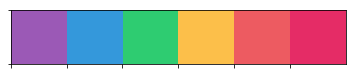

In [2]:
flatui = ["#9b59b6", "#3498db", "#2ecc71","#fcbf4a", "#ed5b61", "#e52c66"]
sns.palplot(sns.color_palette(flatui))

In [3]:
# get list of data files to process
data_files = glob.glob('data/*txt')

In [4]:
# CONSTANTS NECESSARY FOR MAKING SENSE OF THE DATA FILES
col_names = ['stim', 'cond', 'trial', 'amountSS',
             'amountLL', 'delayLL', 'choice', 'space','pct_diff']
stim = { 1:'Pre', 2:'TMS', 3:'Sham' }
cond = { 1:'Ctrl', 2:'Hidden Zero', 3:'Magnitude' }
choice = { 1:'SS', 0:'LL'}

In [5]:
all_data = []
for f in data_files:
    data = pd.read_csv(f, delimiter = '\t', header = None,
                      names = col_names, index_col = False)
    
    data['choice_binary'] = data['choice']
    data['choice'] = [choice[x] for x in data['choice']]
    data['cond'] = [cond[x] for x in data['cond']]
    data['stim'] = [stim[x] for x in data['stim']]
    
    data = data[['stim', 'cond', 'trial', 'amountSS', 
                 'amountLL', 'delayLL', 'choice','choice_binary','pct_diff']]
    
    data['hemi'] = f.split('/')[1].split('s')[0]
    data['sub'] = f.split('.')[0][-2:]
     
    all_data.append(data)
all_data = pd.concat(all_data).reset_index()
all_data['sub_id'] = [x + y for x,y in zip(all_data['sub'], all_data['hemi'])]

In [6]:
def find_K(A1,A2,d1,d2):
    return (A2/A1 - 1)*1.0 / (d2 - (A2/A1)*d1)

In [7]:
#find k_eq for each choice
for n,row in all_data.iterrows():
    k_eq = find_K(all_data.loc[n,'amountSS'],
       all_data.loc[n,'amountLL'],
       0,
       all_data.loc[n,'delayLL'])
    
    all_data.loc[n,'k_eq'] = k_eq

#drop trial level
all_data = all_data.reset_index().set_index(['sub','cond','stim','hemi']).sort_index()

In [8]:
d = all_data.reset_index()
d = d[['sub','cond','stim','hemi','trial','amountSS','amountLL','delayLL','choice']]
d.to_csv('all_data.csv', index = False)


In [9]:
def hyperbolic(A,d,k):
    return A * 1.0/(1.0+k*d)

In [10]:
def errf(params,sub_data):
    #get params and bound on [0,1]
    k,m = params
    k = scipy.stats.logistic.cdf(k)
    m = scipy.stats.logistic.cdf(m)*20
    LL = 0
    for trial in range(sub_data.shape[0]):
        SV_SS = hyperbolic(sub_data.loc[trial,'amountSS'],
                            0, #delayed rewards available now
                            k)
        SV_LL = hyperbolic(sub_data.loc[trial,'amountLL'],
                            sub_data.loc[trial,'delayLL'],
                            k)

        p = 1 / (1 + np.exp(-1*(SV_SS-SV_LL)*m) )
        if sub_data.loc[trial,'choice'] == 'LL':
            p = 1-p
            
        if p < 1e-100:
            p = 1e-100
            
        LL += np.log(p)
    return LL*-1 #minimize negative log likelihood

In [11]:
in_tuples = list(set(all_data.index))

In [12]:
def run_data(in_tup):
    #get the data for this experiment
    sub_data = all_data.loc[in_tup].reset_index().copy()
    sub, exp, tms, hemi = in_tup
    
    #check to see if they made all LL or all SS choices and set k appropriately
    if sum(sub_data['choice'] == 'LL') == sub_data.shape[0]: #all larger later
        k = min(sub_data['k_eq'])
        return in_tup,k
    elif sum(sub_data['choice'] == 'SS') == sub_data.shape[0]: #all SS
        k = max(sub_data['k_eq'])
        return in_tup,k
    
    #run minimization
    else:
        k_init = scipy.stats.logistic.ppf(all_data.median()['k_eq'])
        m_init = -5
        if exp == 'Magnitude':
            m_init = scipy.stats.logistic.cdf(m_init)/10.0
            m_init = scipy.stats.logistic.ppf(m_init)
        params = [k_init,m_init]
        minimizer_kwargs = {"method": 'CG', 'args':(sub_data)}
        try:
            res = basinhopping(errf, params, minimizer_kwargs=minimizer_kwargs,niter=50)
        except:
            return (in_tup,'Failed')
        return (in_tup,res)

# If running fits, execute the next two cells

In [12]:
# pool = multiprocessing.Pool(54)
# res = pool.map(run_data,in_tuples)
# pool.terminate()
# pool.join()

In [13]:
# results_df = {'ll':[], 'k':[], 'm':[],'sub':[],'exp':[],'hemi':[],'tms':[]}
# for x in res:
#     in_tup,o = x
#     sub, exp, tms, hemi = in_tup
#     if o == 'Failed':
#         print in_tup
        
#     else:
#         results_df['ll'].append(o.fun*-1)
#         results_df['k'].append(scipy.stats.logistic.cdf(o.x[0]))
#         results_df['m'].append(scipy.stats.logistic.cdf(o.x[1])*20)
#         results_df['sub'].append(sub)
#         results_df['exp'].append(exp)
#         results_df['tms'].append(tms)
#         results_df['hemi'].append(hemi)
# results_df = pd.DataFrame(results_df)
# results_df['logk'] = np.log(results_df['k'])
# results_df.to_csv(op.abspath('./k_fits_new.csv'), index = False)
# results_df = results_df.set_index(['sub','exp','tms','hemi'])

# Analyze Data

In [94]:
#load data
results_df = pd.read_csv(op.abspath('./k_fits_new.csv'))
results_df['logk'] = np.log(results_df['k'])
results_df['sub_id'] = [str(x) + y for x,y in zip(results_df['sub'],results_df['hemi'])]

## First check out all the data

In [95]:
def remove_intercept_variance(x, group_mean):
    return x - x.mean() + group_mean

In [96]:
results_df['logk_within'] = results_df.groupby('sub_id').logk.transform(remove_intercept_variance,
                                                                  results_df.logk.mean())

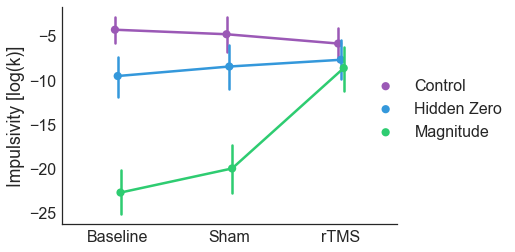

In [16]:
tms_map = {'Pre':'Baseline', 'Sham':'Sham', 'TMS':'rTMS'}
results_df['tms_fig'] = [tms_map[x] for x in results_df['tms']]
exp_map = {'Ctrl':'Control', 'Hidden Zero':'Hidden Zero', 'Magnitude':'Magnitude'}
results_df['exp_fig'] = [exp_map[x] for x in results_df['exp']]

sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (14, 7)})
sns.set_style("white")
ax = sns.pointplot(x = 'tms_fig',
            y = 'logk_within',
            hue = 'exp_fig',
            order = ['Baseline','Sham','rTMS'], 
            data = results_df,
            dodge = .05,
            palette = flatui,
            kwargs = {'error_kw':dict(ecolor='gray')})
sns.despine()
plt.ylabel('Impulsivity [log(k)]')
plt.xlabel('')
l = ax.legend()
l.set_title('')
plt.legend(bbox_to_anchor=(.9, .7), loc=2, borderaxespad=0.)
plt.savefig(op.abspath('./figs/all_conds.png'), dpi = 600, bbox_inches = 'tight')

### Next see if any effects vary by hemisphere

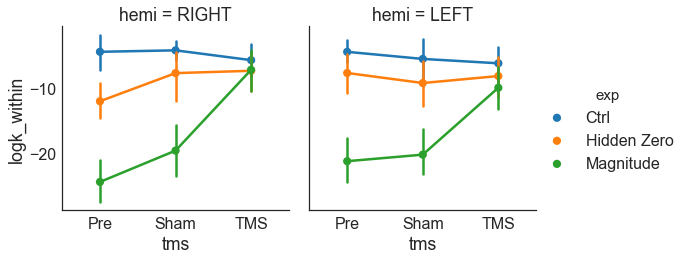

In [62]:
sns.factorplot(x = 'tms',
               y = 'logk_within',
               hue = 'exp',
               col = 'hemi',
               order = ['Pre','Sham','TMS'],
               data = results_df)

## Check out Magnitude Effect

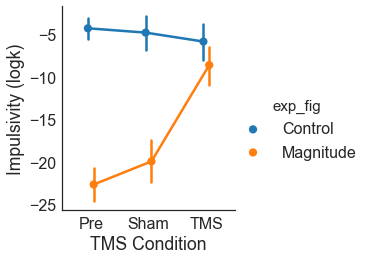

In [22]:
mag = results_df[results_df['exp'] != 'Hidden Zero'].copy()
mag['logk_within'] = mag.groupby('sub_id').logk.transform(remove_intercept_variance,
                                                                  mag.logk.mean())
mag['TMS Condition'] = mag['tms']
sns.factorplot(x = 'TMS Condition',
            y = 'logk_within',
            hue = 'exp_fig' ,
               dodge = .1, 
            order = ['Pre','Sham','TMS'],
            data = mag)
plt.ylabel('Impulsivity (logk)')
sns.despine()
plt.savefig(op.abspath('./figs/Magnitude.png'), dpi = 300)

### First assess whether the effect is significant when comparing to sham

In [153]:
sham = mag[mag['tms'] !='Pre']

In [154]:
model = afex.aov_ez('sub_id', 'logk', data = sham, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df   MSE         F   ges p.value
1         hemi 1, 25 85.17      0.35  .005     .56
2          exp 1, 25 48.45 43.75 ***   .27  <.0001
3     hemi:exp 1, 25 48.45      0.09 .0007     .77
4          tms 1, 25 74.71   9.57 **   .11    .005
5     hemi:tms 1, 25 74.71      0.04 .0005     .85
6      exp:tms 1, 25 21.30 49.27 ***   .15  <.0001
7 hemi:exp:tms 1, 25 21.30      0.71  .003     .41

Sphericity correction method: GG 



In [475]:
#it looks like this may be a disordinal situation where the interaction
#is driving the main effect. Since we are interested in whether we replicated the Figner finding,
#conduct some post-hoc t-tests
ctrl = sham.set_index(['exp','hemi','tms']).sort_index().loc[('Ctrl','RIGHT')]
a = ctrl.loc['Sham'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','right', scipy.stats.ttest_rel(a,b)

ctrl = sham.set_index(['exp','hemi','tms']).sort_index().loc[('Ctrl','LEFT')]
a = ctrl.loc['Sham'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','left', scipy.stats.ttest_rel(a,b)

ctrl = sham.set_index(['exp','tms']).sort_index().loc[('Ctrl')]
a = ctrl.loc['Sham'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','both', scipy.stats.ttest_rel(a,b)

ctrl = sham.set_index(['tms','exp']).sort_index().loc[('Sham')]
a = ctrl.loc['Magnitude'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'mag',scipy.stats.ttest_rel(a,b)

ctrl = sham.set_index(['tms','exp']).sort_index().loc[('TMS')]
a = ctrl.loc['Magnitude'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'mag tms',scipy.stats.ttest_rel(a,b)

tms right Ttest_relResult(statistic=1.3567303443801471, pvalue=0.20205651181755452)
tms left Ttest_relResult(statistic=0.257798958951104, pvalue=0.80031291107642921)
tms both Ttest_relResult(statistic=0.69306846180328108, pvalue=0.4944116043253961)
mag Ttest_relResult(statistic=-7.8842386145200054, pvalue=2.3223345130670767e-08)
mag tms Ttest_relResult(statistic=-2.4004197109644783, pvalue=0.02382814250063945)


## Next assess the effect relative to the pre-test

In [158]:
pre = mag[mag['tms'] !='Sham']

In [156]:
model = afex.aov_ez('sub_id', 'logk', data = pre, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df   MSE          F   ges p.value
1         hemi 1, 25 77.20       0.02 .0003     .89
2          exp 1, 25 17.46 171.66 ***   .39  <.0001
3     hemi:exp 1, 25 17.46       0.08 .0003     .78
4          tms 1, 25 71.04  15.50 ***   .19   .0006
5     hemi:tms 1, 25 71.04       0.98   .01     .33
6      exp:tms 1, 25 18.70  90.35 ***   .27  <.0001
7 hemi:exp:tms 1, 25 18.70       2.71   .01     .11

Sphericity correction method: GG 



In [66]:
#it looks like this may be a disordinal situation where the interaction
#is driving the main effect. Since we are interested in whether we replicated the Figner finding,
#conduct some post-hoc t-tests
ctrl = pre.set_index(['exp','hemi','tms']).sort_index().loc[('Ctrl','RIGHT')]
a = ctrl.loc['Pre'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','right', scipy.stats.ttest_rel(a,b)

ctrl = pre.set_index(['exp','hemi','tms']).sort_index().loc[('Ctrl','LEFT')]
a = ctrl.loc['Pre'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','left', scipy.stats.ttest_rel(a,b)

ctrl = pre.set_index(['exp','tms']).sort_index().loc[('Ctrl')]
a = ctrl.loc['Pre'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['TMS'].sort_values(by = 'sub_id')['logk'].values
print 'tms','both', scipy.stats.ttest_rel(a,b)

ctrl = pre.set_index(['tms','exp']).sort_index().loc[('Pre')]
a = ctrl.loc['Magnitude'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'mag',scipy.stats.ttest_rel(a,b)

tms right Ttest_relResult(statistic=0.55447680614333483, pvalue=0.59034775010739027)
tms left Ttest_relResult(statistic=0.78202917517071024, pvalue=0.44722271069611585)
tms both Ttest_relResult(statistic=0.97434837792964313, pvalue=0.3388622461016999)
mag Ttest_relResult(statistic=-15.574204435069051, pvalue=1.0664619779333989e-14)


## Check out Hidden Zero effect

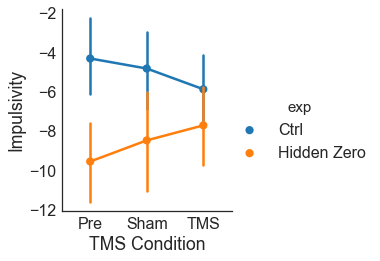

In [19]:
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (7, 8)})
sns.set_style("white")
hz = results_df[results_df['exp'] != 'Magnitude'].copy()
hz['logk_within'] = hz.groupby('sub_id').logk.transform(remove_intercept_variance,
                                                                  hz.logk.mean())
hz['TMS Condition'] = hz['tms']
sns.factorplot(x = 'TMS Condition',
            y = 'logk_within',
            hue = 'exp' ,
            order = ['Pre','Sham','TMS'],
            data = hz)
plt.ylabel('Impulsivity')
sns.despine()
plt.savefig(op.abspath('../fd/figs/committee_meeting/Hidden_Zero.png'), dpi = 300)

### First assess whether the effect is significant when comparing to sham

In [45]:
sham = hz[hz['tms'] !='Pre']

In [38]:
model = afex.aov_ez('sub_id', 'logk', data = sham, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df    MSE      F    ges p.value
1         hemi 1, 25 141.09   0.12   .003     .73
2          exp 1, 25  28.25 7.00 *    .03     .01
3     hemi:exp 1, 25  28.25   0.02 <.0001     .90
4          tms 1, 25  59.10   0.02  .0001     .90
5     hemi:tms 1, 25  59.10   0.07  .0006     .79
6      exp:tms 1, 25  28.55   0.77   .003     .39
7 hemi:exp:tms 1, 25  28.55   0.00 <.0001     .98

Sphericity correction method: GG 



In [49]:
#it looks like this may be a disordinal situation where the interaction
#is driving the main effect. Since we are interested in whether we replicated the Figner finding,
#conduct some post-hoc t-tests
ctrl = sham.set_index(['tms','exp']).sort_index().loc[('Sham')]
a = ctrl.loc['Hidden Zero'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'hidden zero',scipy.stats.ttest_rel(a,b)

hidden zero Ttest_relResult(statistic=-1.9379668985442868, pvalue=0.063558773528699042)


### Next assess the effect relative to the pre-test

In [486]:
pre = hz[hz['tms'] !='Sham']

In [487]:
model = afex.aov_ez('sub_id', 'logk', data = pre, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df    MSE         F   ges p.value
1         hemi 1, 25 122.35      0.22  .005     .64
2          exp 1, 25  18.80 18.82 ***   .06   .0002
3     hemi:exp 1, 25  18.80      1.46  .005     .24
4          tms 1, 25  55.34      0.04 .0004     .84
5     hemi:tms 1, 25  55.34      0.97  .010     .33
6      exp:tms 1, 25  17.36    5.13 *   .02     .03
7 hemi:exp:tms 1, 25  17.36      2.13  .007     .16

Sphericity correction method: GG 



In [488]:
#it looks like this may be a disordinal situation where the interaction
#is driving the main effect. Since we are interested in whether we replicated the Figner finding,
#conduct some post-hoc t-tests
ctrl = pre.set_index(['tms','exp']).sort_index().loc[('Pre')]
a = ctrl.loc['Hidden Zero'].sort_values(by = 'sub_id')['logk'].values
b = ctrl.loc['Ctrl'].sort_values(by = 'sub_id')['logk'].values
print 'hidden zero',scipy.stats.ttest_rel(a,b)

hidden zero Ttest_relResult(statistic=-3.4857239699456009, pvalue=0.0017588251875621996)


# Next directly compare HZ and Magnitude

In [26]:
#subtract out control conditions in order to directly compare effects
sham = results_df[results_df['tms'] !='Pre'].set_index(['exp','tms','sub_id']).sort_index().copy()

sham.loc[('Magnitude','TMS'),'logk'] = (sham.loc[('Magnitude','TMS'),'logk'] - sham.loc[('Ctrl','TMS'),'logk']).values
sham.loc[('Magnitude','Sham'),'logk'] = (sham.loc[('Magnitude','Sham'),'logk'] - sham.loc[('Ctrl','Sham'),'logk']).values
sham.loc[('Hidden Zero','TMS'),'logk'] = (sham.loc[('Hidden Zero','TMS'),'logk'] - sham.loc[('Ctrl','TMS'),'logk']).values
sham.loc[('Hidden Zero','Sham'),'logk'] = (sham.loc[('Hidden Zero','Sham'),'logk'] - sham.loc[('Ctrl','Sham'),'logk']).values

sham = sham.reset_index()
sham = sham[sham['exp'] != 'Ctrl']
sham['logk'] = sham['logk']*-1

In [35]:
a = results_df[results_df['tms'] =='TMS'].set_index(['exp','tms','sub_id']).sort_index().copy()
a.loc[('Hidden Zero','TMS'),'logk'] = (a.loc[('Hidden Zero','TMS'),'logk'] - a.loc[('Ctrl','TMS'),'logk']).values
t,p = scipy.stats.ttest_1samp(a.loc[('Hidden Zero','TMS'),'logk'],0)
print t,p

-2.56301091716 0.0165123699256


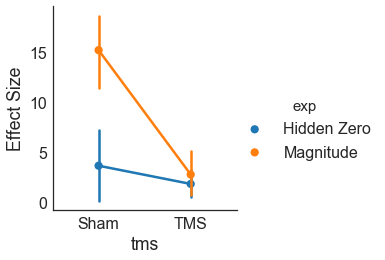

In [32]:
sns.factorplot(x = 'tms',
            y = 'logk',
            hue = 'exp',
            order = ['Sham','TMS'], 
            data = sham)
sns.despine()
plt.ylabel('Effect Size')

In [56]:
model = afex.aov_ez('sub_id', 'logk', data = sham, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df    MSE         F   ges p.value
1         hemi 1, 25 119.48      0.06  .001     .80
2          exp 1, 25  33.91 30.15 ***   .14  <.0001
3     hemi:exp 1, 25  33.91      0.05 .0003     .82
4          tms 1, 25  81.37 16.91 ***   .18   .0004
5     hemi:tms 1, 25  81.37      0.20  .003     .66
6      exp:tms 1, 25  18.33 41.86 ***   .11  <.0001
7 hemi:exp:tms 1, 25  18.33      0.76  .002     .39

Sphericity correction method: GG 



//anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: hemi

  warnings.warn(x, RRuntimeWarning)


In [57]:
s = sham.set_index(['exp','tms']).sort_index()

interaction = s.loc[('Magnitude',"TMS")].sort_values(by = 'sub_id')['logk'].values -\
s.loc[('Magnitude',"Sham")].sort_values(by = 'sub_id')['logk'].values -\
s.loc[('Hidden Zero',"TMS")].sort_values(by = 'sub_id')['logk'].values +\
s.loc[('Hidden Zero',"Sham")].sort_values(by = 'sub_id')['logk'].values 



In [18]:
#subtract out control conditions in order to directly compare effects
pre = results_df[results_df['tms'] !='Sham'].set_index(['exp','tms','sub_id']).sort_index().copy()

pre.loc[('Magnitude','TMS'),'logk'] = (pre.loc[('Magnitude','TMS'),'logk'] - pre.loc[('Ctrl','TMS'),'logk']).values
pre.loc[('Magnitude','Pre'),'logk'] = (pre.loc[('Magnitude','Pre'),'logk'] - pre.loc[('Ctrl','Pre'),'logk']).values
pre.loc[('Hidden Zero','TMS'),'logk'] = (pre.loc[('Hidden Zero','TMS'),'logk'] - pre.loc[('Ctrl','TMS'),'logk']).values
pre.loc[('Hidden Zero','Pre'),'logk'] = (pre.loc[('Hidden Zero','Pre'),'logk'] - pre.loc[('Ctrl','Pre'),'logk']).values

pre = pre.reset_index()
pre = pre[pre['exp'] != 'Ctrl']
pre['logk'] = pre['logk']*-1

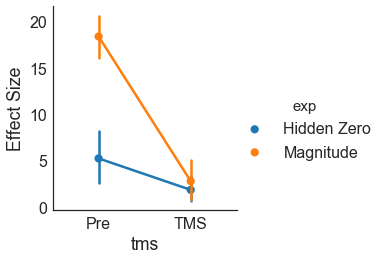

In [19]:
sns.factorplot(x = 'tms',
            y = 'logk',
            hue = 'exp',
            order = ['Pre','TMS'], 
            data = pre)
sns.despine()
plt.ylabel('Effect Size')

In [23]:
#perform nonparametric test of percent
diff = pre.set_index(['exp','tms'])

hz_pre = diff.loc[('Hidden Zero','Pre')].sort_values(by = 'sub_id')['logk'].values
hz_tms = diff.loc[('Hidden Zero','TMS')].sort_values(by = 'sub_id')['logk'].values

mag_pre = diff.loc[('Magnitude','Pre')].sort_values(by = 'sub_id')['logk'].values
mag_tms = diff.loc[('Magnitude','TMS')].sort_values(by = 'sub_id')['logk'].values


mag_sign = sum(mag_tms < mag_pre)
hz_sign = sum(hz_tms < hz_pre)

nsubs = len(mag_tms)
oddsratio, pvalue = stats.fisher_exact([[mag_sign, nsubs - mag_sign], 
                                        [hz_sign, nsubs - hz_sign]]) 
    
print oddsratio, pvalue

13.0 0.0112809475456


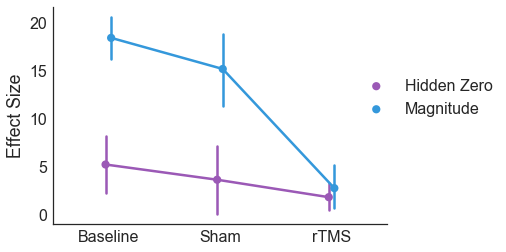

In [71]:
s = sham[sham['tms'] == 'Sham']
fig_df = pd.concat([s,pre])
tms_map = {'Pre':'Baseline', 'Sham':'Sham', 'TMS':'rTMS'}
fig_df['tms'] = [tms_map[x] for x in fig_df['tms']]
sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (14, 7)})
ax = sns.pointplot(x = 'tms',
            y = 'logk',
            hue = 'exp',
            dodge = .05,
            order = ['Baseline','Sham','rTMS'], 
            palette = flatui,
            data = fig_df)
sns.despine()
plt.ylabel('Effect Size')
plt.xlabel('')
l = ax.legend()
l.set_title('')
plt.legend(bbox_to_anchor=(.9, .7), loc=2, borderaxespad=0.)
plt.savefig(op.abspath('./figs/effect.png'), dpi = 600, bbox_inches = 'tight')



In [513]:
model = afex.aov_ez('sub_id', 'logk', data = pre, within=['exp','tms'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: logk
        Effect    df   MSE         F   ges p.value
1         hemi 1, 25 33.11      1.25   .01     .27
2          exp 1, 25 39.40 32.77 ***   .26  <.0001
3     hemi:exp 1, 25 39.40      0.41  .004     .53
4          tms 1, 25 40.19 63.55 ***   .41  <.0001
5     hemi:tms 1, 25 40.19    4.34 *   .05     .05
6      exp:tms 1, 25 31.93 31.40 ***   .22  <.0001
7 hemi:exp:tms 1, 25 31.93      0.03 .0003     .86

Sphericity correction method: GG 



# Percent SS Analysis

In [13]:
perc_df =all_data.reset_index().groupby(['sub','stim','cond','hemi']).mean().reset_index()
perc_df['sub_id'] = [str(x) + y for x,y in zip(perc_df['sub'],perc_df['hemi'])]
perc_df['choice_binary_logit'] = [scipy.special.logit(x) for x in perc_df['choice_binary']]

In [14]:
perc_df['choice_binary_within'] = perc_df.groupby('sub').choice_binary.transform(remove_intercept_variance,
                                                                  perc_df.choice_binary.mean())

NameError: name 'remove_intercept_variance' is not defined

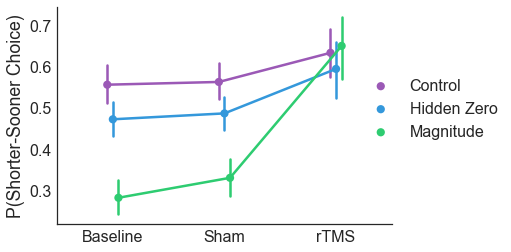

In [105]:
tms_map = {'Pre':'Baseline', 'Sham':'Sham', 'TMS':'rTMS'}
perc_df['tms_fig'] = [tms_map[x] for x in perc_df['stim']]
exp_map = {'Ctrl':'Control', 'Hidden Zero':'Hidden Zero', 'Magnitude':'Magnitude'}
perc_df['exp_fig'] = [exp_map[x] for x in perc_df['cond']]

sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (14, 7)})
sns.set_style("white")
ax = sns.pointplot(x = 'tms_fig',
            y = 'choice_binary_within',
            hue = 'exp_fig',
            order = ['Baseline','Sham','rTMS'], 
            data = perc_df,
            dodge = .1,
            palette = flatui,
            kwargs = {'error_kw':dict(ecolor='gray')})
sns.despine()
plt.ylabel('P(Shorter-Sooner Choice)')
plt.xlabel('')
l = ax.legend()
l.set_title('')
plt.legend(bbox_to_anchor=(.9, .7), loc=2, borderaxespad=0.)
plt.savefig(op.abspath('./figs/perc_SS_analysis.png'), dpi = 600, bbox_inches = 'tight')

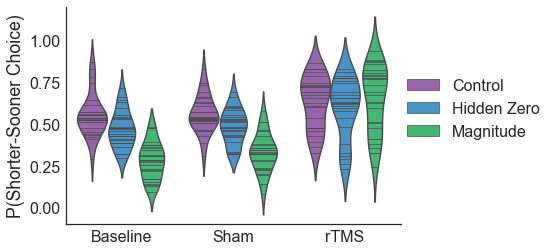

In [133]:
tms_map = {'Pre':'Baseline', 'Sham':'Sham', 'TMS':'rTMS'}
perc_df['tms_fig'] = [tms_map[x] for x in perc_df['stim']]
exp_map = {'Ctrl':'Control', 'Hidden Zero':'Hidden Zero', 'Magnitude':'Magnitude'}
perc_df['exp_fig'] = [exp_map[x] for x in perc_df['cond']]

sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (14, 7)})
sns.set_style("white")
ax = sns.violinplot(x = 'tms_fig',
            y = 'choice_binary_within',
            hue = 'exp_fig',
            order = ['Baseline','Sham','rTMS'], 
            data = perc_df,
            dodge = .1,
            inner="stick",
            palette = flatui,
            kwargs = {'error_kw':dict(ecolor='gray')})
sns.despine()
plt.ylabel('P(Shorter-Sooner Choice)')
plt.xlabel('')
l = ax.legend()
l.set_title('')
plt.legend(bbox_to_anchor=(1, .7), loc=2, borderaxespad=0.)
plt.savefig(op.abspath('./figs/perc_SS_analysis_subs.png'), dpi = 600, bbox_inches = 'tight')

# Figner replication

In [21]:
ctrl = perc_df[perc_df['cond'] == 'Ctrl']
sham = ctrl[ctrl['stim'] != 'Pre']
pre = ctrl[ctrl['stim'] != 'Sham']

In [22]:
model = afex.aov_ez('sub_id', 'choice_binary_logit', 
                    data = pre, within=['stim'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: choice_binary_logit
     Effect    df  MSE      F  ges p.value
1      hemi 1, 25 0.61   0.90  .02     .35
2      stim 1, 25 0.46 4.30 *  .07     .05
3 hemi:stim 1, 25 0.46   0.23 .004     .64

Sphericity correction method: GG 



//anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: hemi

  warnings.warn(x, RRuntimeWarning)


# Magnitude Effect

In [88]:
#sham
mag = perc_df[perc_df['cond'] != 'Hidden Zero']
sham = mag[mag['stim'] != 'Pre']

model = afex.aov_ez('sub_id', 'choice_binary_logit', data = sham, within=['stim','cond'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: choice_binary_logit
          Effect    df  MSE         F    ges p.value
1           hemi 1, 25 1.22      0.22   .004     .64
2           stim 1, 25 0.90 25.82 ***    .24  <.0001
3      hemi:stim 1, 25 0.90      0.14   .002     .71
4           cond 1, 25 0.42  11.23 **    .06    .003
5      hemi:cond 1, 25 0.42      1.11   .006     .30
6      stim:cond 1, 25 0.41 22.30 ***    .11  <.0001
7 hemi:stim:cond 1, 25 0.41      0.01 <.0001     .92

Sphericity correction method: GG 



In [89]:
#baseline
pre = mag[mag['stim'] != 'Sham']

model = afex.aov_ez('sub_id', 'choice_binary_logit', data = pre, within=['stim','cond'], between = ['hemi'])
print(model)

Anova Table (Type 3 tests)

Response: choice_binary_logit
          Effect    df  MSE         F   ges p.value
1           hemi 1, 25 1.02      0.22  .003     .64
2           stim 1, 25 1.03 29.98 ***   .30  <.0001
3      hemi:stim 1, 25 1.03      0.40  .006     .53
4           cond 1, 25 0.38 19.43 ***   .09   .0002
5      hemi:cond 1, 25 0.38      0.87  .005     .36
6      stim:cond 1, 25 0.41 31.01 ***   .15  <.0001
7 hemi:stim:cond 1, 25 0.41      0.08 .0004     .78

Sphericity correction method: GG 



# Hidden Zero Effect

In [92]:
hz = perc_df[perc_df['cond'] != 'Magnitude']
sham = hz[hz['stim'] != 'Pre']
print sham.shape

model = afex.aov_ez('sub_id', 'choice_binary_logit', data = sham, within=['stim','cond'], between = ['hemi'])
print(model)

(108, 14)
Anova Table (Type 3 tests)

Response: choice_binary_logit
          Effect    df  MSE         F    ges p.value
1           hemi 1, 25 1.59      0.01  .0003     .92
2           stim 1, 25 0.57    7.65 *    .07     .01
3      hemi:stim 1, 25 0.57      0.46   .004     .50
4           cond 1, 25 0.13 14.39 ***    .03   .0008
5      hemi:cond 1, 25 0.13      0.01 <.0001     .93
6      stim:cond 1, 25 0.18      0.53   .002     .47
7 hemi:stim:cond 1, 25 0.18      0.05  .0001     .83

Sphericity correction method: GG 



In [93]:
pre = hz[hz['stim'] != 'Sham']
print pre.shape
model = afex.aov_ez('sub_id', 'choice_binary_logit', data = pre, within=['stim','cond'], between = ['hemi'])
print(model)

(108, 14)
Anova Table (Type 3 tests)

Response: choice_binary_logit
          Effect    df  MSE        F   ges p.value
1           hemi 1, 25 1.41     0.56   .01     .46
2           stim 1, 25 0.59  9.47 **   .08    .005
3      hemi:stim 1, 25 0.59     0.10 .0009     .76
4           cond 1, 25 0.16 12.61 **   .03    .002
5      hemi:cond 1, 25 0.16     0.16 .0004     .69
6      stim:cond 1, 25 0.30     0.44  .002     .52
7 hemi:stim:cond 1, 25 0.30     0.16 .0008     .69

Sphericity correction method: GG 



# Choice consistency analysis

In [115]:
for n, row in results_df.iterrows():
    sub = row['sub']
    if sub < 10:
        sub = '0' + str(sub)
    else:
        sub = str(sub)
    results_df.loc[n,'sub_id'] = sub
    cond = row['exp']
    tms = row['tms']
    hemi = row['hemi']
    
    ntrials = all_data.loc[(sub, cond, tms, hemi)].shape[0]


In [118]:
results_df = results_df.set_index(['sub_id','exp','tms','hemi'])
# all_data = all_data.set_index(['sub','cond','stim','hemi']).sort_index()

In [120]:
for row in set(all_data.index):
    k = results_df.loc[row,'k']
    sub_data = all_data.loc[row].reset_index()

    correct = 0
    ntrials = sub_data.shape[0]
    for trial in range(ntrials):
        SV_SS = hyperbolic(sub_data.loc[trial,'amountSS'],
                            0, #delayed rewards available now
                            k)
        SV_LL = hyperbolic(sub_data.loc[trial,'amountLL'],
                            sub_data.loc[trial,'delayLL'],
                            k)

        if sub_data.loc[trial,'choice'] == 'SS':
            if SV_SS > SV_LL:
                correct += 1
        else: #
            if SV_SS < SV_LL:
                correct += 1
    correct = correct * 1.0/ntrials 
    
    results_df.loc[row,'p_corr'] = correct

In [121]:
results_df = results_df.reset_index()

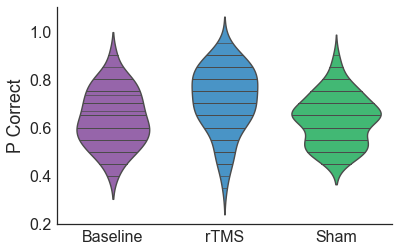

In [128]:
tms_map = {'Pre':'Baseline', 'Sham':'Sham', 'TMS':'rTMS'}
results_df['tms_fig'] = [tms_map[x] for x in results_df['tms']]
exp_map = {'Ctrl':'Control', 'Hidden Zero':'Hidden Zero', 'Magnitude':'Magnitude'}
results_df['exp_fig'] = [exp_map[x] for x in results_df['exp']]
results_df['p_corr_within'] = results_df.groupby('sub').p_corr.transform(remove_intercept_variance,
                                                                  results_df.p_corr.mean())

sns.set_context('paper',font_scale = 2,rc={"figure.figsize": (14, 7)})
sns.set_style("white")
ax = sns.violinplot(x = 'tms_fig',
            y = 'p_corr',
            inner="stick",
#             hue = 'exp_fig',
#             order = ['Baseline','Sham','rTMS'], 
            data = results_df,
            dodge = .05,
            palette = flatui,
            kwargs = {'error_kw':dict(ecolor='gray')})
sns.despine()
plt.ylabel('P Correct')
plt.xlabel('')
# l = ax.legend()
# l.set_title('')
plt.legend(bbox_to_anchor=(.9, .7), loc=2, borderaxespad=0.)
plt.savefig(op.abspath('p_correct.png'), dpi = 600, bbox_inches = 'tight')

In [142]:
pre = results_df[results_df['tms'] != 'Sham']
model = afex.aov_ez('sub_id', 'p_corr', 
                    data = pre, within=['tms','exp'])
print(model)

Anova Table (Type 3 tests)

Response: p_corr
   Effect          df  MSE         F ges p.value
1     tms       1, 14 0.01 25.22 *** .18   .0002
2     exp 1.40, 19.65 0.01   7.81 ** .14    .006
3 tms:exp 1.88, 26.27 0.01    3.20 + .06     .06

Sphericity correction method: GG 



In [140]:
pre = results_df[results_df['tms'] != 'Pre']
model = afex.aov_ez('sub_id', 'p_corr', 
                    data = pre, within=['tms','exp'])
print(model)

Anova Table (Type 3 tests)

Response: p_corr
   Effect          df  MSE         F ges p.value
1     tms       1, 14 0.01 20.26 *** .18   .0005
2     exp 1.91, 26.70 0.01    2.73 + .06     .09
3 tms:exp 1.60, 22.46 0.01      1.20 .02     .31

Sphericity correction method: GG 



# K_EQ analysis

In [149]:
all_data = all_data.reset_index()
all_data['log_k_eq'] = map(np.log, all_data['k_eq'])

In [150]:
#compute mediam split
a = all_data.set_index(['cond','stim','sub_id']).sort_index()
for row in set(a.index):
    k_eq = a.loc[row,'k_eq'].values
    cut = pd.qcut(k_eq, 2, labels = ['lowkeq','highkeq']).get_values()
    a.loc[row,'k_eq_split'] = cut
a = a.reset_index().groupby(['cond','stim','sub_id','k_eq_split']).mean().reset_index()

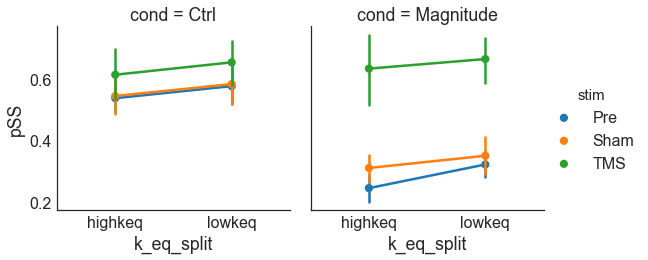

In [145]:
a = a[a['cond'] != 'Hidden Zero']
a['pSS'] = a['choice_binary']
sns.factorplot(x="k_eq_split", y="pSS", hue="stim", 
           units = 'sub_id', col = 'cond', kind = 'point', data=a);
plt.savefig('k_eq_median_split.png', dpi = 300, bbox_inches = 'tight')


In [83]:
mag = a[a['cond'] == 'Ctrl']
pre = mag[mag['stim'] != 'Sham']

model = afex.aov_ez('sub_id', 'choice_binary', 
                    data = pre, within=['stim','k_eq_split'])
print(model)

Anova Table (Type 3 tests)

Response: choice_binary
           Effect    df  MSE      F    ges p.value
1            stim 1, 26 0.04 3.92 +    .05     .06
2      k_eq_split 1, 26 0.01 3.84 +    .01     .06
3 stim:k_eq_split 1, 26 0.02   0.00 <.0001     .98

Sphericity correction method: GG 



In [51]:
mag = a[a['cond'] == 'Magnitude']
pre = mag[mag['stim'] != 'Sham']

model = afex.aov_ez('sub_id', 'choice_binary', 
                    data = pre, within=['stim','k_eq_split'])
print(model)

Anova Table (Type 3 tests)

Response: choice_binary
           Effect    df  MSE         F  ges p.value
1            stim 1, 26 0.07 49.94 ***  .46  <.0001
2      k_eq_split 1, 26 0.02    5.13 *  .02     .03
3 stim:k_eq_split 1, 26 0.02      0.75 .003     .40

Sphericity correction method: GG 

